# Wstępna analiza IUM
Rafał Bosko <br>

In [1]:
import jsonlines
import json
import pandas as pd
import math
import matplotlib.pyplot as plt
import datetime
from datetime import date
import time
import numpy as np

## Problem biznesowy
<blockquote>
Predykcja czy dana sesja użytkownika zakończy się zakupem na podstawie danych sesji. Skuteczna klasyfikacja sesji, które zakończą się zakupem umożliwi konsultantom szybsze rozwiązywanie problemów
</blockquote>

## Biznesowe kryterium sukcesu
System powinien przewidywać sesje, które zakończą się zakupem z efektywnością porównywalną z innymi istniejącymi rozwiązaniami wymienionymi w [literaturze](#Literatura). Dostarczenie takiej informacji pozwoli nie tylko na szybsze rozwiązywanie problemów, ale i zidentyfikowanie m.in. trendów sprzedażowych.

## Zadanie modelowania
Zadaniem jest klasyfikacja binarna odpowiadająca na pytanie "Czy sesja użytkownika zakończy się zakupem?".

Zmienną celu natomiast będzie liczbowa miara jakości generowanych predykcji dla wciąż trwających sesji, zdefiniowana jako *Accuracy* w sekcji poświęconej kryteriom sukcesu.

Do dyspozycji mamy historyczne dane składające się z:
* bazy użytkowników
* katalogu produktów
* historia sesji
* dane dotyczące wysyłki zakupionych produktów

Analiza tych danych historycznych, przydatnych do zbudowania modelu generującego predykcje znajduje się w sekcji o analizie zbioru danych.

## Analityczne kryterium sukcesu
Uzyskanie odpowiednio wysokiej skuteczności predykcji zapewnia miara *Accuracy* obliczana jako: 
$\frac{TP + TN}{TP + TN + FP + FN}$

Rozważaliśmy również *F1 score*, obliczanej jako: $2 * \frac{Precision * Recall}{Precision + Recall}$ gdzie: <br>
$Precision = \frac{TP}{TP + FP}$ oraz $Recall = \frac{TP}{TP + FN}$

Nie zdecydowaliśmy jednak wstępnie na tą miarę, ponieważ:
* jest trudniejsza do interpretacji
* F1 sprawdza się lepiej od Accuraccy w przypadku, gdy jest duża dysproporcja między klasami, a w naszym przypadku takiego problemu nie ma

## Analiza zbioru danych
Wstępna analiza danych pozwoliła nam odrzucić dane o przesyłkach, ponieważ te dane są dostarczane po zakupie i nie wpływają na zakup, podobna sytuacja dotyyczyła dwóch kolumn z tabeli sessions: typ zdarzenia i id zakupu, ponieważ to warość typu zdarzenia (zakup czy nie) będziemy przewidywali, a id zakupu jest ściśle skorelowane z typem zdarzenia.

Informacje zawarte w pozostałych tabelach są dostępne w trakcie trwania sesji, więc przeszliśmy do bardziej szczegółowej analizy tego fragmentu danych.

Postanowiliśmy wyróżnić ze zbioru danych następujące informacje:
* [*user_id*](#userId) - identyfikator użytkownika
* [*purchase*](#purchase) - wartość boolowska odpowiadająca na pytanie czy sesja zakończyła się zakupem
* [*offered_discount*](#discount) - wysokość zniżki w procentach
* [*item_views*](#item_views) - liczba obejrzanych przedmiotów w danej sesji
* [*unique_item_views*](#unique_item_views) - liczba przejrzanych unikalnych przedmiotów
* [*unique_categories*](#unique_categories) - liczba przejrzanych unikalnych kategorii

## Brakujące bądź niepoprawne wartości
Kontynuowaliśmy analizę danych, sprawdzając czy dane są poprawne, oraz czy wszystkie informacje są ze sobą powiązane w prawidłowy sposób. W wypadku niemożliwych do usunięcia błędów wartości, wskazanym będzie prośba do dostawcy danych o ich poprawienie.


In [2]:
def getDataFromJson(fileName):
    with open('../data/raw/'+fileName) as f:
        lines = f.read().splitlines()
    
    dataFrame = pd.DataFrame(lines)
    dataFrame.columns = ['json_element']
    return pd.json_normalize(dataFrame['json_element'].apply(json.loads))

### Analiza poprawności danych - sesje
Dane sesji w większości wypadków nie posiadają braków - tylko w kolumnie *purchase_id* występują wartości puste. Kolumna ta jednak sygnalizuje, że brak zakupu produktu oznaczany jest wartością null. Wartość ta zawsze znajduje się wspólnie z wartością VIEW_PRODUCT w kolumnie *event_type*, więc można założyć, że dane te są poprawne.

Ważnym jest jednak sprawdzenie pomyślnego połączenia danych sesji z danymi użytkownika. Zostało to wykonane w analizie poprawności danych użytkownika. 

In [3]:
sessionsDataFrame = getDataFromJson('sessions.jsonl')
sessionsDataFrame.info()

sessionsDataFrame["event_type"].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37003 entries, 0 to 37002
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   session_id        37003 non-null  int64  
 1   timestamp         37003 non-null  object 
 2   user_id           37003 non-null  int64  
 3   product_id        37003 non-null  int64  
 4   event_type        37003 non-null  object 
 5   offered_discount  37003 non-null  int64  
 6   purchase_id       5686 non-null   float64
dtypes: float64(1), int64(4), object(2)
memory usage: 2.0+ MB


count            37003
unique               2
top       VIEW_PRODUCT
freq             31317
Name: event_type, dtype: object

### Analiza poprawności danych - użytkownicy
Dane użytkowników nie posiadają żadnych braków.

Dokonane zostało sprawdzenie, czy wszystkie *user_id* z tabeli danych sesji pokrywają się z *user_id* z tabeli użytkownika, by nie pominąć przypadku, gdy w kolumnie *user_id* wpisany jets niepoprawny użytkownik. Sprawdzenie to poszło pomyślnie.

In [4]:
usersDataFrame = getDataFromJson('users.jsonl')
usersDataFrame.head()

,user_id,name,city,street
0,102,Mariusz Czerniec,Wrocław,pl. Północna 59/33
1,103,Adrianna Luberda,Poznań,ulica Szpitalna 80/66
2,104,Sylwia Adrian,Gdynia,plac Wyszyńskiego 774
3,105,Julianna Milej,Poznań,al. Podleśna 75/81
4,106,Ada Fiołka,Warszawa,plac Jagiellońska 432


In [5]:
usersDataFrame.info()

with open("../data/raw/users.jsonl") as file:
  lines = [n.strip() for n in file.readlines()]
  user_raw_data = [json.loads(n) for n in lines]
    
with open("../data/raw/sessions.jsonl") as file:
  lines = [n.strip() for n in file.readlines()]
  session_raw_data = [json.loads(n) for n in lines]

user_data_ids = set(user['user_id'] for user in user_raw_data)
for session in session_raw_data:
    assert session['user_id'] in user_data_ids

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  200 non-null    int64 
 1   name     200 non-null    object
 2   city     200 non-null    object
 3   street   200 non-null    object
dtypes: int64(1), object(3)
memory usage: 6.4+ KB


### Analiza poprawności danych - produkty
Dane użytkowników nie posiadają żadnych braków.

Dokonane zostało sprawdzenie, czy wszystkie *product_id* z tabeli danych sesji pokrywają się z *product_id* z tabeli produktów, by nie pominąć przypadku, gdy w kolumnie *product_id* wpisany jets niepoprawny produkt. Sprawdzenie to poszło pomyślnie.

In [6]:
productsDataFrame = getDataFromJson('products.jsonl')
productsDataFrame.head()

,product_id,product_name,category_path,price
0,1001,Telefon Siemens Gigaset DA310,Telefony i akcesoria;Telefony stacjonarne,58.97
1,1002,Kyocera FS-1135MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,2048.50
2,1003,Kyocera FS-3640MFP,Komputery;Drukarki i skanery;Biurowe urządzeni...,7639.00
3,1004,Fallout 3 (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99
4,1005,Szalone Króliki Na żywo i w kolorze (Xbox 360),Gry i konsole;Gry na konsole;Gry Xbox 360,49.99


In [7]:
productsDataFrame.info()
productsDataFrame["price"].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     319 non-null    int64  
 1   product_name   319 non-null    object 
 2   category_path  319 non-null    object 
 3   price          319 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 10.1+ KB


count     319.000000
mean      247.787962
std       813.788548
min         1.000000
25%        24.990000
50%        41.000000
75%        92.995000
max      7639.000000
Name: price, dtype: float64

In [8]:
with open("../data/raw/products.jsonl") as file:
  lines = [n.strip() for n in file.readlines()]
  product_raw_data = [json.loads(n) for n in lines]
    
product_data_ids = set(product['product_id'] for product in product_raw_data)
for session in session_raw_data:
    assert session['product_id'] in product_data_ids

### Przykładowe rekordy

In [9]:
# sessions = pd.read_csv("../data/processed/merged_dataset", sep=' ')
# sessions.head()
   
sessionsDataFrame = getDataFromJson('sessions.jsonl')
sessionsDataFrame.head()

,session_id,timestamp,user_id,product_id,event_type,offered_discount,purchase_id
0,124,2021-05-26T01:18:01,102,1277,VIEW_PRODUCT,20,NaN
1,124,2021-05-26T01:19:32,102,1276,VIEW_PRODUCT,20,NaN
2,125,2021-07-16T14:16:04,102,1002,VIEW_PRODUCT,20,NaN
3,125,2021-07-16T14:17:23,102,1079,VIEW_PRODUCT,20,NaN
4,125,2021-07-16T14:19:23,102,1080,VIEW_PRODUCT,20,NaN


## Analiza bardziej szczegółowa
### Dane o sesjach
Na początku postanowiliśmy zbadać czy w zbiorze danych o sesjach nie ma wyraźnej dominacji przez sesje określonego typu: czy jest podobna ilość tych które się zakończyły zakupem i tych w których do zakupu nie doszło:

In [10]:
### Initial data processing -> grouping sessions by id
sessionEndShopping = 0
sessionEndNotShopping = 0
sessionsDataFrame.sort_values(by=['session_id'])
sessions = []  #[124, 'VIEW_PRODUCT', [1621984681.0, 1621984772.0], 5]
               #[session_id, buy/not_buy, [session_timestamps], discount]

for index, row in sessionsDataFrame.iterrows(): #merge session logs by id
    currentTimeStamp = datetime.datetime.strptime(row['timestamp'], "%Y-%m-%dT%H:%M:%S").timestamp()
    if len(sessions)==0:
        sessions.append([row['session_id'], row['event_type'], [currentTimeStamp], row['offered_discount']])
    else:
        if sessions[len(sessions)-1][0] == row['session_id']:
            if sessions[len(sessions)-1][1] != 'BUY_PRODUCT':
                sessions[len(sessions)-1][1] = row['event_type']
            
            sessions[len(sessions)-1][2].append(currentTimeStamp)
        else:
            sessions.append([row['session_id'], row['event_type'], [currentTimeStamp], row['offered_discount']])

### Stodunek sesji które zakończyły się zakupem i tych w których do zakupu nie doszło

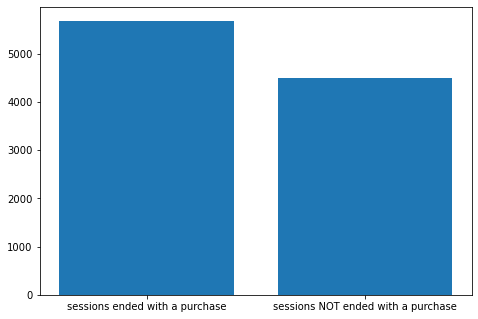

Różnica:  11.78%


In [11]:
for session in sessions:
    if session[1] == 'BUY_PRODUCT':
        sessionEndShopping += 1
    else:
        sessionEndNotShopping += 1
    
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['sessions ended with a purchase', 'sessions NOT ended with a purchase']
sessionsCount = [sessionEndShopping,sessionEndNotShopping]
ax.bar(langs,sessionsCount)
plt.show()

diff = abs(sessionEndNotShopping-sessionEndShopping)/(sessionEndShopping+sessionEndNotShopping)
print('Różnica:  '+str(round(diff*100, 2))+'%')

Okazuje się że sesji zakończonych zakupem jest nieco więcej, niż tych w których do zakupu nie doszło. Nie istnieje jednak tutaj problem wynikający z niezbalansowania danych - różnica między sesjami zakończonymi zakupem a sesjami niezakończonymi nie jest wystarczająco duża.

Kolejnym interesującym parametrem sesji jest ich czas trwania:

In [12]:
allSessionTimes = []
positiveSessionTimes = [] #    end with purchase
negativeSessionTimes = [] #not end with purchase

for session in sessions:
        session[2].sort()
        dt = session[2][len(session[2])-1] - session[2][0]
        sessionDurationInMinutes = int(round(dt/60))
        allSessionTimes.append(sessionDurationInMinutes)
        
        if session[1] == 'VIEW_PRODUCT':
            negativeSessionTimes.append(sessionDurationInMinutes)
        else:
            positiveSessionTimes.append(sessionDurationInMinutes)
       
allSessionTimes.sort()
positiveSessionTimes.sort()
negativeSessionTimes.sort()

allSessionTimesCounts = []
positiveTimeCounts = []
negativeTimeCounts = []
positiveVsnegative = []

for i in range(0, allSessionTimes[len(allSessionTimes)-1]+1): ### range from 0 to maxSessionTime -> count each duration
    allSessionTimesCounts.append(allSessionTimes.count(i))
    positiveVsnegative.append(positiveSessionTimes.count(i)-negativeSessionTimes.count(i))
    positiveTimeCounts.append(positiveSessionTimes.count(i))
    negativeTimeCounts.append(-negativeSessionTimes.count(i))

#### Rozkład średniego czasu (w minutach) trwania sesji

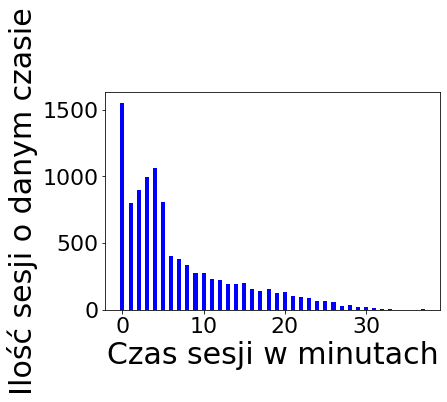

In [13]:
plt.rcParams.update({'font.size': 22})
    
ax = plt.subplot(111)
plt.rcParams["figure.figsize"] = (30,10)
x = np.arange(allSessionTimes[len(allSessionTimes)-1]+1)
ax.bar(x, allSessionTimesCounts, width=0.5, color='b', align='center')       
plt.xlabel("Czas sesji w minutach",  fontsize=30)
plt.ylabel("Ilość sesji o danym czasie",  fontsize=30)
plt.show()

#### Wykres różnic, między ilością sesji które zakończyły się zakupem a tych które zakończyły się jedynie oglądaniem produktów:

Kolor niebieski - sesje zakończone zakupem

Kolor czerwony - sesje które się nie zakończyły zakupem

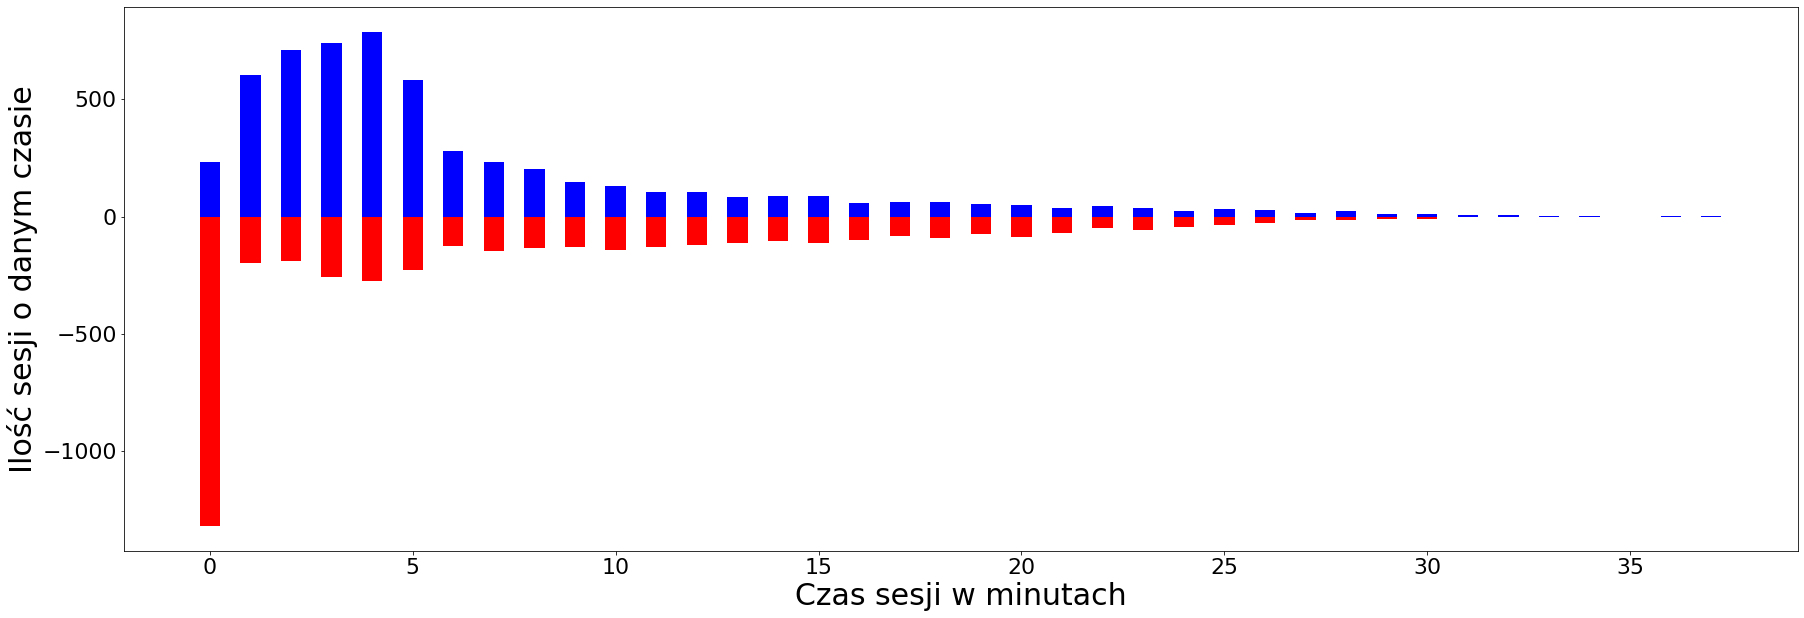

In [14]:
plt.rcParams.update({'font.size': 22})

ax = plt.subplot(111)
plt.rcParams["figure.figsize"] = (30,10)
ax.bar(x, positiveTimeCounts, width=0.5, color='b', align='center')
ax.bar(x, negativeTimeCounts, width=0.5, color='r', align='center')
plt.xlabel("Czas sesji w minutach",  fontsize=30)
plt.ylabel("Ilość sesji o danym czasie",  fontsize=30)
plt.show()

Okazuje się że w zbiorze danych jest dużo sesji które trwały poniżej minuty. Między innymi jest to spowodowane występowaniem sesji, które składały się z jednego wpsiu (użytkownik oglądał jeden produkt). Takie zjawisko można wytłumaczyć omyłkowym kliknięciem na link do sklepu/produktu i opuszczenie strony zaraz po załadowaniu, zatem nie zakładamy że takie sesje też się będą zdarzać.

Dane o sesjach świadczą że użytkownicy względnie szybko podejmują decyzję o zakupie (w ciągu 7-8 minut), po upływie tego czasu większość sesji kończy się bez zakupu.

Kolejnym czynnikiem wpływającym bezpośrednio na decyzję o zakupie są zniżki

In [15]:
allDiscounts = []
positiveDiscounts = []
negativeDiscounts = []

for session in sessions:
        allDiscounts.append(session[3])
        if session[1] == 'VIEW_PRODUCT':
            negativeDiscounts.append(session[3])
        else:
            positiveDiscounts.append(session[3])
            
allDiscounts.sort()
positiveDiscounts.sort()
negativeDiscounts.sort()

allDiscountsCount = []
positiveVsNegative = []

for i in range(0, allDiscounts[len(allDiscounts)-1]+5, 5): ### range from 0 to maxSessionTime -> count each duration
    allDiscountsCount.append(allDiscounts.count(i))
    positiveVsNegative.append(positiveDiscounts.count(i) - negativeDiscounts.count(i))

x = np.arange(0, allDiscounts[len(allDiscounts)-1]+5,5)

#### Ilość zniżek o danej wartości

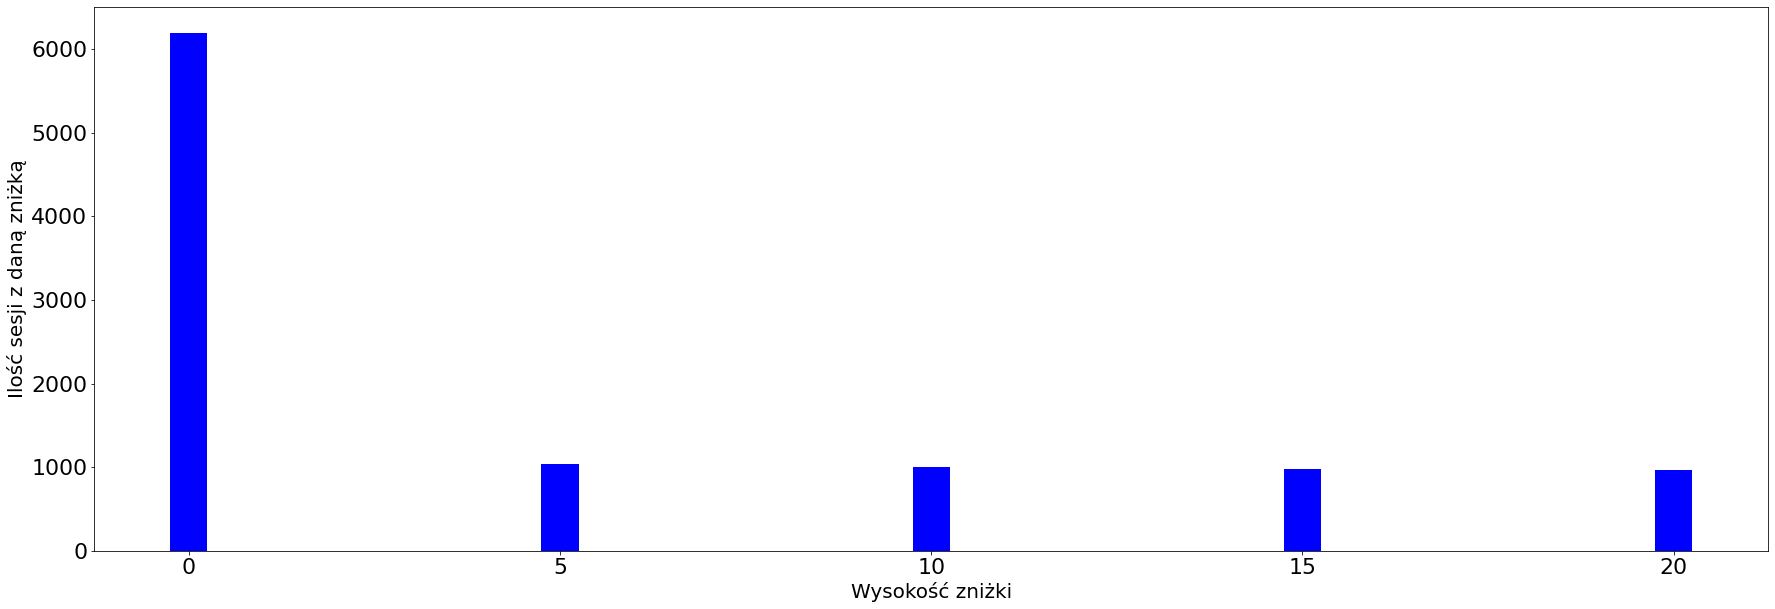

In [16]:
ax = plt.subplot(111)
ax.bar(x, allDiscountsCount, width=0.5, color='b', align='center')   
plt.rcParams["figure.figsize"] = (30,10)
plt.xlabel("Wysokość zniżki",  fontsize=20)
plt.ylabel("Ilość sesji z daną zniżką",  fontsize=20)
plt.show()

#### Ilość sesji zakońzonych zakupem przy danej zniżce:

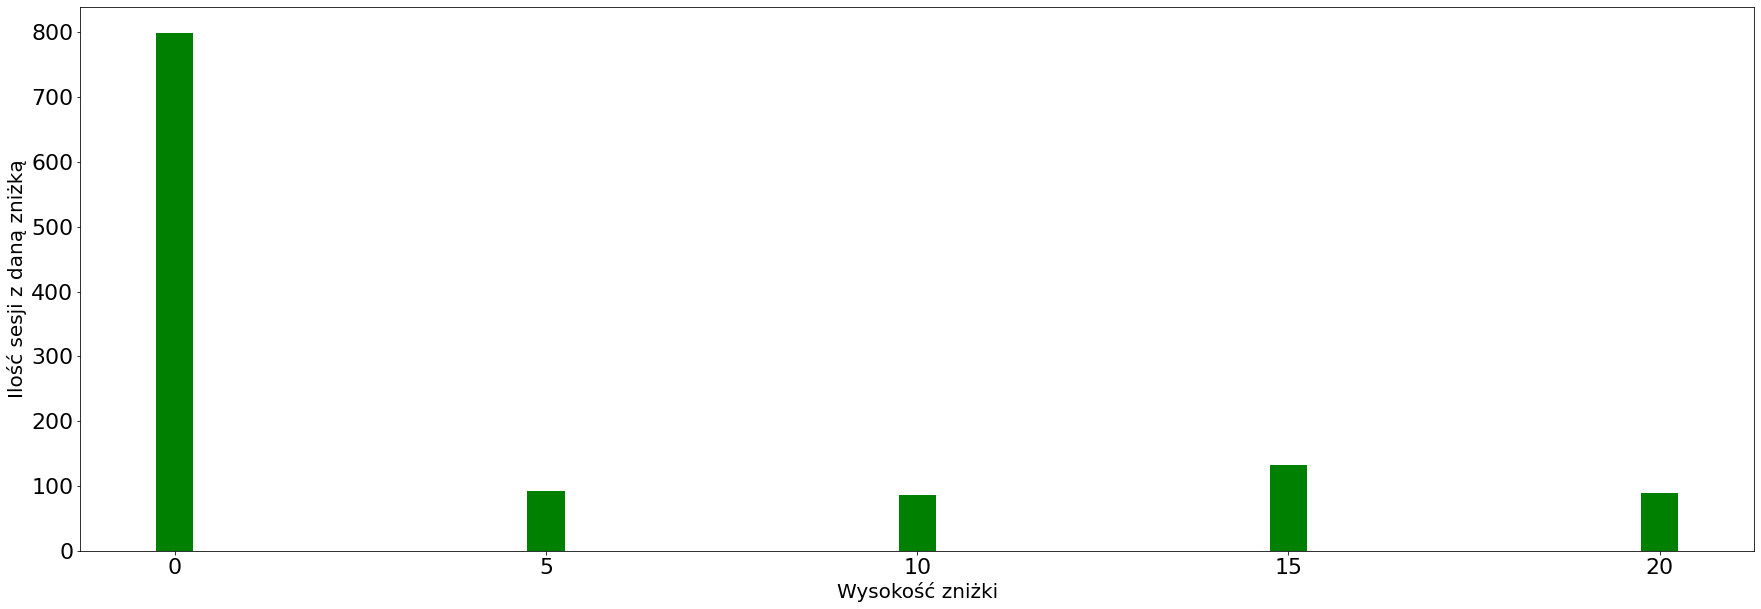

In [17]:
ax = plt.subplot(111)
ax.bar(x, positiveVsNegative, width=0.5, color='g', align='center')   
plt.rcParams["figure.figsize"] = (30,10)
plt.xlabel("Wysokość zniżki",  fontsize=20)
plt.ylabel("Ilość sesji z daną zniżką",  fontsize=20)
plt.show()

Z danych dostarczonych o zniżkach wynika że łączna ilość sesji zakończonych zakupem przy niezerowej zniżce jest niewielka, co prawda rozkład wartości odpowiada rozkładowi ilości proponowanych zniżek, ale ich ilość jest niewielka (o rząd wielkości mniejsza) w porównaniu do tego ile razy była proponowana dana zniżka.

## Dane o produktach

In [18]:
def checkIfUnique(collection, name):
    for element in collection:
        if element[0] == name:
            return False
    return True;

def getSubCategories(collection, name):
    for element in collection:
        if element[0] == name:
            element[2] += 1
            return element[1]
    return None

def addCategories(collection, categoryArray, depth):
    if len(categoryArray) > depth:
        category = categoryArray[depth]
        if checkIfUnique(collection, category):
            collection.append([category,[],0])
        subCategories = getSubCategories(collection, category)
        addCategories(subCategories, categoryArray, depth+1)
        
def printCollection1(collection, string):
    if len(collection) == 0:
        print(string[2:])
    else:
        for element in collection:
            printCollection1(element[1], string+': '+element[0]+'('+str(element[2]) +')')
        
def printCollection2(collection, length):
    for element in collection:
        print(element[0]+':  ',end = '')
        printCollection2(element[1], length+len(element[0]))

Z poniżej wyznaczonych kategorii produktów wynika, że znaczącą większość produktów w sklepie stanowią "Gry i konsole", a w nich przeważającym składnikiem są "Gry komputerowe". Są to dane niezbalansowane, wynikające ze specjalizacją sklepu, dla którego szykujemy biznesowe rozwiązanie predykcyjne.

In [19]:
sessionsDataFrame = getDataFromJson('products.jsonl')

mainCategories = []

for index, row in sessionsDataFrame.iterrows():
    categories = row['category_path'].split(';')
    addCategories(mainCategories, categories, 0)
    
printCollection1(mainCategories,'')


Telefony i akcesoria(12): Telefony stacjonarne(1)
Telefony i akcesoria(12): Telefony komórkowe(2)
Telefony i akcesoria(12): Akcesoria telefoniczne(9): Zestawy głośnomówiące(5)
Telefony i akcesoria(12): Akcesoria telefoniczne(9): Zestawy słuchawkowe(4)
Komputery(28): Drukarki i skanery(9): Biurowe urządzenia wielofunkcyjne(9)
Komputery(28): Monitory(17): Monitory LCD(17)
Komputery(28): Tablety i akcesoria(2): Tablety(2)
Gry i konsole(243): Gry na konsole(41): Gry Xbox 360(32)
Gry i konsole(243): Gry na konsole(41): Gry PlayStation3(9)
Gry i konsole(243): Gry komputerowe(202)
Sprzęt RTV(36): Video(33): Odtwarzacze DVD(2)
Sprzęt RTV(36): Video(33): Telewizory i akcesoria(31): Okulary 3D(1)
Sprzęt RTV(36): Video(33): Telewizory i akcesoria(31): Anteny RTV(30)
Sprzęt RTV(36): Przenośne audio i video(2): Odtwarzacze mp3 i mp4(2)
Sprzęt RTV(36): Audio(1): Słuchawki(1)


## Testy jakościowe atrybutów - Chi²
Postanowiliśmy również przygotować testy dotyczące jakości poszczególnych atrybutów i ich powiązaniu z atrybutem informującym o zakończeniu sesji kupnem produktu. Taka informacja pozwoli wybrać zestaw najbardziej obiecujących parametrów do utworzenia modelu.

Poniżej znajduje się definicja funkcji która realizuje wyliczanie wartości chi², jak również i prezentacja wyników działania funkcji w wypadku przypadków brzegowych - z jednej strony dwóch atrybutów losowych o różnych formatach, a z drugiej - dwóch atrybutów, gdzie drugi z nich jest pierwszym atrybutem, pomniejszonym o stałą wartość liczbową.

In [20]:
def chi_squared(two_attributes_values_array, categories=[-1, -1]):
    
    #Ustalenie liczby różnych kategorii pierwszego i drugiego atrybutu - -1 w
    #drugim parametrze funkcji oznacza explicite liczenie różnych wartości dla
    #integerów albo stringów, inna wartość niedodatnia oznacza liczbę równych interwałów
    #zamkniętych po lewej i otwartych po prawej, które "pomieszczą" floaty celem
    #ich liczenia w dalszych etapach testu.  
    
    categories_array = []
    
    for i in range(2):
        if categories[i] <= -1:
            categories_array.append(np.sort
                                    (np.unique
                                     (two_attributes_values_array[:, i]))
                                        .tolist())
            
        else:
            categories_array.append(np.linspace(
                                    np.amin(two_attributes_values_array[:, i]),
                                    np.amax(two_attributes_values_array[:, i]), 
                                    categories[i])
                                    .tolist())
            
    #Tworzenie matrycy zliczającej ilość wystąpień poszczególnych par wartości
    #między dwoma atrybutami, na podstawie której tworzone są sumy wartości 
    #przewidywanych i finalna wartość testu chi kwadrat.
    freq_of_occurence_array = np.zeros((len(categories_array[0]), 
                                        len(categories_array[1])))
    
    for row_of_two_attr in two_attributes_values_array:
        index_first_col = sum(n <= row_of_two_attr[0] 
                              for n in categories_array[0])
        index_second_col = sum(n <= row_of_two_attr[1] 
                               for n in categories_array[1])
        freq_of_occurence_array[index_first_col-1][index_second_col-1] += 1
    #print(freq_of_occurence_array)
    
    #Obliczanie wartości chi kwadrat
    #źródło - https://www.geeksforgeeks.org/python-pearsons-chi-square-test/
    n = np.sum(freq_of_occurence_array)
    n_i_array = np.sum(freq_of_occurence_array, axis=1)
    n_j_array = np.sum(freq_of_occurence_array, axis=0)
    chi = 0
    
    for i in range(freq_of_occurence_array.shape[0]):
        for j in range(freq_of_occurence_array.shape[1]):
            expected = (n_i_array[i]*n_j_array[j])/n
            
            if freq_of_occurence_array[i][j] == 0:
                continue
                
            chi += (freq_of_occurence_array[i][j]-expected)**2/expected
    return chi

In [21]:
#column_random = np.random.randint(0,5,size=(1000, 1))
column_random = np.random.uniform(10.0,15.0,size=(1000, 1))
df_random_noise = pd.DataFrame(column_random)
df_random_noise[1] = 0.0
df_random_noise.rename(columns={0: 'first_col', 1: 'second_col'}, inplace=True)

for index, value in df_random_noise.iterrows():
    df_random_noise.at[index, 'second_col'] = np.random.randint(2)
    
print("Chi value for rand: " + str(chi_squared(df_random_noise.to_numpy(),[5,-1])))

for index, _ in df_random_noise.iterrows():
    df_random_noise.at[index, 'second_col'] = df_random_noise.at[index, 'first_col'] - 0.5
    
print("Chi value for correlated attributes: " + str(chi_squared(df_random_noise.to_numpy(),[5,5])))

Chi value for rand: 5.153664235136949
Chi value for correlated attributes: 3250.224


In [45]:
sessionsDataFrame = getDataFromJson('sessions.jsonl')

# user_id - identyfikator użytkownika
# purchase - wartość boolowska odpowiadająca na pytanie czy sesja zakończyła się zakupem
# offered_discount - wysokość zniżki w procentach
# item_views - liczba obejrzanych przedmiotów w danej sesji
# unique_item_views - liczba przejrzanych unikalnych przedmiotów
# unique_categories - liczba przejrzanych unikalnych kategorii

user_eventtype_df = sessionsDataFrame[["user_id","event_type"]].copy()
purchaseid_eventtype_df = sessionsDataFrame[["purchase_id","event_type"]].copy()
offered_discount_eventtype_df = sessionsDataFrame[["offered_discount","event_type"]].copy()

#przetworzenie purchase_id na purchase - atrybut mówiący o tym czy zakup się 
#dokonał w sesji czy nie

purchaseid_eventtype_df["purchase_id"] = (purchaseid_eventtype_df["purchase_id"] > 0).astype(bool)

print("Chi value for user_id and event_type: " + str(chi_squared(user_eventtype_df.to_numpy())))
print("Chi value for purchase_id and event_type: " + str(chi_squared(purchaseid_eventtype_df.to_numpy())))
print("Chi value for offered_discount and event_type: " + str(chi_squared(offered_discount_eventtype_df.to_numpy())))


Chi value for user_id and event_type: 560.0092694406593
Chi value for purchase_id and event_type: 27378.458097992054
Chi value for offered_discount and event_type: 2.958363536316471


Naiwne sprawdzenie testem chi kwadrat wskazuje, że (co oczywiste) zakup przedmiotu zawsze koreluje z wystąpieniem taga BUY_PRODUCT. Co ciekawe jednak, wartość tego testu dla korelacji między zniżką daną do zakupu a zakupem jest znacznie mniejsza niż wartość identyfikatora użytkownika, który kupuje bądź nie kupuje dany przedmiot.

## Literatura

* Esmeli, R., Bader-El-Den, M. & Abdullahi, H. Towards early purchase intention prediction in online session based retailing systems. Electron Markets 31, 697–715 (2021). https://doi.org/10.1007/s12525-020-00448-x
* S. Luo, S. Zhang and H. Cong, "Research on Consumer Purchasing Prediction Based on XGBoost Algorithm," 2021 IEEE International Conference on Artificial Intelligence and Computer Applications (ICAICA), 2021, pp. 1173-1176. https://doi.org/10.1109/ICAICA52286.2021.9497944
* Bruno J.D. Jacobs, Bas Donkers, Dennis Fok (2016) Model-Based Purchase Predictions for Large Assortments. Marketing Science 35(3):389-404. https://doi.org/10.1287/mksc.2016.0985
* Haubner, Nicolas & Setzer, Thomas. (2021). Hybrid Recommender Systems for Next Purchase Prediction Based on Optimal Combination Weights.
[Źródło](https://www.researchgate.net/publication/349711825_Hybrid_Recommender_Systems_for_Next_Purchase_Prediction_Based_on_Optimal_Combination_Weights)